In [1]:
import  torch;
import  numpy;
import  matplotlib.pyplot   as      plt;
from    scipy               import  interpolate;
from    typing              import  List, Dict, Tuple;

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `MODEL` class defines an object that can act like the function $F$.

In [45]:
class MODEL(torch.nn.Module):
    """ 
    Objects of the MODEL class are designed to model the right-hand side of a DDE. Consider the 
    following DDE:
        x'(t) = F(x(t), x(t - \tau), t)     t \in [0, T]
        x(t)  = x_0                         t \in [-\tau, 0]
    A MODEL object is supposed to act like the function F in the expression above. In other words, 
    it defines a function which accepts three arguments: x, y, and t. If x = x(t), y = x(t - \tau),
    then the returned value  can be interpreted as the right hand side of a DDE.
    """

    def __init__(self, c_0 : float = 2.0, c_1 : float = 2.0):
        """ 
        Currently, this MODEL class is set up to act as a logistic map:
            F(x, y, t) = c_0*x*(1 - c_1*y)
        (there is no explicit dependence on t). Thus, the arguments c_0 and c_1 define the function 
        implied by this MODEL object.
        """
        
        # Call the super class initializer. 
        super(MODEL, self).__init__();

        # Set model parameters.
        self.Params = torch.nn.parameter.Parameter(torch.tensor([c_0, c_1], dtype = torch.float32, requires_grad = True));



    def forward(self, x : torch.Tensor, y : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        """
        A MODEL object defines the right hand side of a DDE (see class doc-string above). Thus, the 
        forward map defines that function. We expect x, y, and t to be single element tensors. This 
        function then returns
            F(x, y, t) = c_0*x*(1 - c_1*y)
        
        --------------------------------------------------------------------------------------------
        Arguments:

        x, y: 1D tensors representing the first two arguments of the right hand side of the above 
        DDE. These should have the same length.

        t: a single element tensor whose lone value represents the third argument to the DDE above.
        """

        # Checks.
        assert(len(x.shape) == 1);
        assert(len(y.shape) == 1);
        assert(x.numel()    == y.numel());
        assert(t.numel()    == 1);
        
        # compute, return the output         
        Output : torch.Tensor = self.Params[0]*x*(1. - self.Params[1]*y);
        return Output;

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

In [46]:
def DDE_Solve(F : torch.nn.Module, x_0 : torch.Tensor, tau : torch.Tensor, T : torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    This function computes an approximate solution to the following DDE:
        x'(t)   = F(x(t), x(t - \tau), t)   t \in [0, T]
        x(t)    = x_0                       t \in [-\tau, 0]
    Here, x \in \mathbb{R}^d.
    
    --------------------------------------------------------------------------------------------
    Arguments:

    F : This is a torch.nn.Module object which represents the right-hand side of the DDE (See 
    above). 

    x_0 : This is a 1D tensor whose value represents the initial state of the DDE (see above).

    tau : This is a single element tensor whose lone element represents the time delay.

    T : this is a single element tensor whose lone element represents the final time. 

    --------------------------------------------------------------------------------------------
    Returns:

    A two element tuple. The first element holds a 2D tensor whose kth column holds the state of 
    the system (as solved by the solver) at the kth time value. The second is another 1D tensor 
    whose kth element holds the kth time value. Note: We only approximate the solution in the 
    interval [0, T].
    """

    # Checks
    assert(len(x_0.shape)   == 1);
    assert(tau.numel()      == 1);
    assert(T.numel()      == 1);

    # Find the dimension of x. 
    d   : int           = x_0.shape[0];

    # Define the time-step to be 0.01 of the delay
    dt  : float         = 0.01*tau.item() if tau != 0 else 1.0;

    # Find the number of time steps. We add +1 for the initial time.
    N   : int           = int(torch.floor(T/dt).item());

    # compute the difference in indices between x(t) and x(t - tau).
    # This is just tau/dt = tau/(.01*tau) = 100.
    dN  : int           = 100;

    # tensor to hold the solution, time steps. Note the +1 is to account for 
    # the fact that we want the solution at N+1 times: 0, dt, 2dt, ... , Ndt.
    x_trajectory    : torch.Tensor  = torch.empty([d, N + 1],   dtype = torch.float32);
    t_trajectory    : torch.Tensor  = torch.linspace(start = 0, end = N*dt, steps = N + 1);

    # Set the first column of x to the IC.  
    x_trajectory[:, 0]             = x_0;
    
    # Compute the solution!
    for i in range(0, N):
        # Find x at the i+1th time value. Note that if t < tau (equivalently, i < dN), then 
        # t - \tau < 0, which means that x(t - \tau) = x_0. 
        if i >= dN:
            x_trajectory[:, i + 1] = x_trajectory[:, i] + dt*F(x = x_trajectory[:, i], y = x_trajectory[:, i - dN], t = torch.tensor(float(i*dN)));
        else:
            x_trajectory[:, i + 1] = x_trajectory[:, i] + dt*F(x = x_trajectory[:, i], y = x_0,          t = torch.tensor(float(i*dN)));

    # All done!
    return (x_trajectory, t_trajectory);

### Generate True solution

Generate the true solution and plot it!

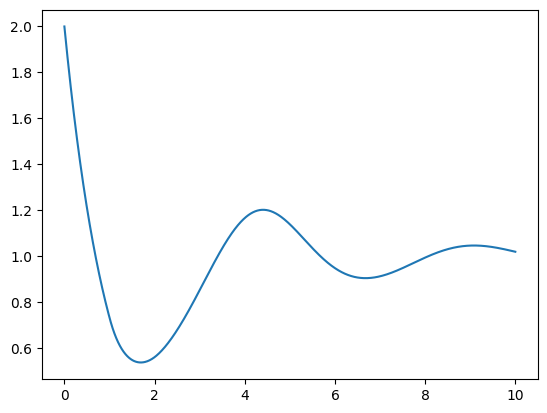

In [47]:
# Set up an object to represent the vector field that we want to learn
F_True          = MODEL(c_0 = 1.0, c_1 = 1.0);
x_0_True        = torch.tensor([2.0]);
tau_True        = torch.tensor(1.0);
T_True          = torch.tensor(10.0);
x_trajectory_True, t_trajectory_True  = DDE_Solve(F = F_True, x_0 = x_0_True, tau = tau_True, T = T_True);

# Now, set up tau, final time. We will attempt to learn tau.
plt.plot(t_trajectory_True.detach().numpy(), x_trajectory_True.reshape(-1).detach().numpy());

### Autograd.Function for Neural DDEs

Forward pass - solve the DDE with $f(x, y, \theta) $ as the vector field and $x_0$ as initial condition

Backward pass - Solve the adjoint equation to return the gradient of the trajectory at final time with respect to $\theta$ and $\tau$

In [63]:
class DDE_adjoint_1D(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, F : torch.nn.Module, x_0 : torch.Tensor, tau : torch.Tensor, T : torch.Tensor, F_Params : torch.Tensor) -> torch.Tensor:
        """ 
        --------------------------------------------------------------------------------------------
        Arguments:

        F: A torch Module object which represents the right-hand side of the DDE,
                x'(t) = F(x(t), x(t - tau), t)      t \in [0, T]
        
        x_0: A d-element 1D tensor whose kth value specifies the kth component of the starting position.

        tau: A single element tensor whose lone element specifies our best guess for the time delay.

        T: A single element tensor whose lone element specifies the final simulation time.

        F_Params: A tensor housing the parameters of the model, F.

        Note: we compute gradients with respect to x_0, tau, and F_Params.

        --------------------------------------------------------------------------------------------
        Returns: 

        A 2D tensor whose kth column specifies the state at the kth time step.        
        """ 

        # Run checks. 
        assert(len(x_0.shape)   == 1);
        assert(tau.numel()      == 1);
        assert(T.numel()        == 1);

        # We don't want gradients with respect to T.
        ctx.mark_non_differentiable(T);

        # Compute the forward solution using the DDE solver. 
        x_trajectory, t_trajectory = DDE_Solve(F, x_0, tau, T);
            
        # Save non-tensor arguments for backwards.
        ctx.F       = F; 

        # Save tensor arguments for backwards
        ctx.save_for_backward(x_0, tau, T, x_trajectory, t_trajectory, F_Params);
        
        # All done!
        return x_trajectory.clone();
        
    
    @staticmethod
    def backward(ctx, grad_y : torch.Tensor) -> Tuple[torch.Tensor]:
        # recover information from the forward pass
        F               : torch.nn.Module                   = ctx.F;
        x_0, tau, T, x_Trajectory, t_trajectory, F_Params   = ctx.saved_tensors;
        d               : int                               = x_0.numel();

        # extract the parameters from the list and find how many there are
        F_Params        : torch.Tensor      = F.Params;
        N_Params        : int               = F_Params.shape[0];
        
        # Find out how many time points there are.
        dt              : float             = 0.01*tau.item() if tau != 0 else 1.0;
        N               : int               = int(torch.floor(T/dt).item());
        
        # Number of indices between one time delay. This is just tau/dt = tau/(.01*tau) = 100.
        dN              : int               = 100;

        # define the augmented system
        p               : torch.Tensor      = torch.zeros([N + 1, 1], dtype = torch.float32); # we need to remember the second dimension since the eq for p is a DDE
        p_tau           : torch.Tensor      = torch.tensor([0.], dtype = torch.float32);
        p_theta         : torch.Tensor      = torch.zeros_like(F_Params);

        # Initialize the last component of p. 
        p[-1]                               = 1.;

        # we need the sensitivity matrix evaluated at future times in the equation for the adjoint
        # so we need to store it
        df_dy = torch.zeros([N + 1, d], dtype = torch.float32);
        df_dx = torch.zeros([N + 1, d], dtype = torch.float32);

        for i in range(N, 0, -1):  
            # Enable gradient tracking! We need this to compute the gradients of F. 
            torch.set_grad_enabled(True);
            
            # Fetch x, y from the ith time step.
            x_i : torch.Tensor  = x_Trajectory[:, i     ].requires_grad_(True);
            y_i : torch.Tensor  = x_Trajectory[:, i - dN].requires_grad_(True) if i >= dN else x_0;
            t_i : torch.Tensor  = t_trajectory[i];

            # Evaluate F at the current state.
            F_i : torch.Tensor  = F(x_i, y_i, t_i);

            # find the gradient of F w.r.t. x, y, and theta
            df_dx_i, df_dy_i, df_dtheta = torch.autograd.grad(outputs = F_i, inputs = (x_i, y_i, F_Params));

            # We are all done tracking gradients.
            torch.set_grad_enabled(False);

            # Check if the gradient with respect to x or y is None. If so, then F doesn't depend on 
            # that parameter. We set the gradient to zero and let the user know.
            if(df_dx_i == None):
                df_dx[i, :] = torch.zeros(d);
                print("No dependence on x(t)!");
            else:
                df_dx[i, :] = df_dx_i;
            
            if(df_dy_i == None):
                df_dy[i, :] = torch.zeros(d);
                print("No dependence on the delay term!");
            else:
                df_dy[i, :] = df_dy_i;
        
            # Find the delay equation for p's, use this to find p at the previous time step.
            # since p(t) = 0 for t > T the delay term vanishes if t + tau > T
            if i >= N - dN:
                p[i - 1] = p[i] - dt*(df_dx[i]*p[i]);
            else:
                p[i - 1] = p[i] - dt*(df_dx[i]*p[i] + df_dy[i + dN, :]*p[i + dN]);
                
            # update the gradient for theta
            p_theta : torch.Tensor = p_theta - dt*p[i]*df_dtheta;

            # Update the gradient for tau. Note that the integral for dL/dtau goes from 
            # tau to T (after a change of variables).
            if i > dN:
                x_i_tau : torch.Tensor = x_Trajectory[:, i - dN];
                y_i_tau : torch.Tensor = x_Trajectory[:, i - 2*dN] if i - 2*dN >= 0 else x_0;
                t_i_tau : torch.Tensor = torch.tensor(float(i - dN));
                
                f_i_tau : torch.Tensor = F(x_i_tau, y_i_tau, t_i_tau);
                p_tau   : torch.Tensor = p_tau - dt * p[i] * df_dy[i, :] * f_i_tau;

        """
        plt.figure(0);
        plt.plot(t_trajectory, p.detach().numpy());
        plt.yscale('log');
        plt.figure(1);
        plt.plot(t_trajectory, df_dx.reshape(-1).detach().numpy());
        plt.figure(2);
        print(df_dy);
        plt.plot(t_trajectory, df_dy.reshape(-1).detach().numpy());
        """
        
        # All done... The kth return argument represents the gradient for the kth argument to forward.
        return None, p[0].clone(), p_tau, None, p_theta;

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `MODEL` object. Recall that a `MODEL` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `MODEL`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

In [64]:
class NDDE_1D(torch.nn.Module):
    def __init__(self, Model : torch.nn.Module):
        """
        Arguments:

        Model: This is a torch Module object which acts as the function "F" in a DDE: 
            x'(t) = F(x(t), x(t - \tau), t)     for t \in [0, T]
            x(t)  = x_0                         for t \in [-\tau, 0]
        Thus, the Model should accept three arguments: x(t), x(t - \tau), and t. 
        """

        # Call the super class initializer.
        super(NDDE_1D, self).__init__();

        # Set the model.
        self.Model = Model;
        

    def forward(self, x_0 : torch.Tensor, tau : torch.Tensor, T : torch.Tensor):
        """
        Arguments: 

        x_0: the initial position. We assume that x(t) = x_0 for t \in [-\tau, 0]. Thus, x_0 
        defines the initial state of the DDE. x_0 should be a 1D tensor.

        tau: The time delay in the DDE. This should be a single element tensor.

        T: The final time in our solution to the DDE (See above). This should be a single 
        element tensor.
        """

        # Run checks.
        assert(len(x_0.shape)   == 1);
        assert(tau.numel()      == 1);
        assert(T.numel()        == 1);

        # Fetch the model and its parameters.
        Model           : torch.nn.Module   = self.Model;
        Model_Params    : torch.Tensor      = Model.Params;

        # Evaluate the neural DDE using the Model
        Trajectory = DDE_adjoint_1D.apply(Model, x_0, tau, T, Model_Params);
        return Trajectory;
        

### Auxillary functions

These are functions which we need to run the Epochs. Currently, this consists of `loss_fn` and `Interpolate_Trajectory`. The former defines the loss we try to minimize while the latter allows us to interpolate the solution of a DDE. The latter is needed because $tau$ changes as we train the model (and chaning tau changes the step size, which changes the times at which the DDE solver finds solutions to the DDE).

In [65]:
def loss_fn(predictions : torch.Tensor, targets : torch.Tensor, tau : torch.Tensor) -> torch.Tensor:
    l : float = 0.;
    return torch.mean(torch.square(predictions - targets)) + l*tau**2;



def Interpolate_Trajectory(x_trajectory : torch.Tensor, t_trajectory : torch.Tensor, N_Interp : int):
    """ 
    This function allows us to interpolate a vector valued function, x(t). We assume that the 
    kth column of X represents the value of x at the time t_trajectory[k]. This function 
    interpolates those samples to determine the value of x at 0, dt, d2t, ... , 
    t_trajectory[-1], where dt = t_trajectory[-1]/N.

    --------------------------------------------------------------------------------------------
    Arguments:

    x_trajectory: This is a d x N tensor whose kth column represents the value of some (vector 
    valued) function, x(t), at the kth time value. 

    t_trajectory: This is a N element tensor whose kth entry holds the kth time value.

    N_Interp: The number of time values at which we want the interpolated solution.
    """

    # Checks
    assert(len(x_trajectory.shape) == 2);
    assert(len(t_trajectory.shape) == 1);
    assert(x_trajectory.shape[1]   == t_trajectory.shape[0]);

    # Convert everything to numpy ndarrays.
    x_trajectory_np : numpy.ndarray = x_trajectory.detach().numpy();
    t_trajectory_np : numpy.ndarray = t_trajectory.detach().numpy();
    
    # interpolate
    f_interp = interpolate.interp1d(t_trajectory_np, x_trajectory_np);
    
    # Fetch the final time. 
    t_i : float = t_trajectory_np[0];
    T   : float = t_trajectory_np[-1];

    # find the values of the trajectory at the new time steps
    new_t_trajectory_np         : numpy.ndarray = numpy.linspace(t_i, T, N_Interp);
    interpolated_x_trajectory   : numpy.ndarray = f_interp(new_t_trajectory_np);

    return torch.from_numpy(interpolated_x_trajectory);

### Setup the Model we want to optimize


In [66]:
# Set up a NDDE_1D object. We will try to train the enclosed model to match the one we used to generate the above plot.
Model       = MODEL(c_0 = 2.0, c_1 = 2.0);
DDE_Module  = NDDE_1D(Model);

# Pick a starting position, tau, and x_0
x_0     = torch.clone(x_0_True).requires_grad_(True);
T       = torch.clone(T_True).requires_grad_(False);
tau     = torch.tensor(2.0,     requires_grad = True);

# Select the optimizer.
Param_List : List = list(Model.parameters()) + [tau];
Optimizer = torch.optim.Adam(Param_List, lr = 0.1);

### Run the Epochs!

In [67]:
####################################################################################################
# Setup. 

# Pick the number of epochs. 
n_epochs = 1000;

# Set up buffers to track history.
loss_iterations         = torch.zeros(n_epochs);
parameter_iterations    = torch.zeros(n_epochs, 2);
tau_iterations          = torch.zeros(n_epochs);



####################################################################################################
# Run the epochs!

for epoch in range(n_epochs):    
    # find the predicted trajectories with current tau, parameter values.
    Predicted_Trajectory : torch.Tensor = DDE_Module(x_0, tau, T);

    if torch.any(torch.isnan(Predicted_Trajectory)) == False:
        # find the time steps for the output trajectory
        N : int = Predicted_Trajectory.shape[1];

        # interpolate the data at the new time steps. Note that we need to do this 
        # every epoch because tau changes each epoch, and tau controls the step size.
        Target_Trajectory : torch.Tensor = Interpolate_Trajectory(
                                            x_trajectory    = x_trajectory_True, 
                                            t_trajectory    = t_trajectory_True,
                                            N_Interp        = N);

        # Compute the loss!
        Loss : torch.Tensor = loss_fn(Predicted_Trajectory, Target_Trajectory, tau);

        # Check if loss is low enough to stop
        if Loss < 0.01:
            print("converged after %d epochs" % epoch);
            break;

        # Otherwise, run one step of the optimizer!
        Optimizer.zero_grad();
        Loss.backward();
        Optimizer.step();

        # Report loss and stuff.
        if epoch % 10 == 0:
            print(  "%4d: "      % epoch,
                    " Loss = %7.5f" % Loss.item(), 
                    " | tau = %7.5f" % tau.item(), 
                    " | grad tau = %9.5f" % tau.grad.item(),
                    " | Params = %7.5f, %7.5f" % (Model.Params[0], Model.Params[1]), 
                    " | grad Params = %9.5f, %9.5f" % (Model.Params.grad[0], Model.Params.grad[1]));
            #plt.plot(Predicted_Trajectory[0].detach().numpy());

        # save the data for printing later
        loss_iterations[epoch]          = Loss;
        parameter_iterations[epoch, :]  = Model.Params;
        tau_iterations[epoch]           = tau;

    else:    
        print("Something went wrong :(");
        break;

# Report final tau, parameter values.
print("Final values:");
print("tau = %7.5f, c_0 = %7.5f, c_1 = %7.5f" % (tau.item(), Model.Params[0], Model.Params[1]));

   0:   Loss = 1.56273  | tau = 1.90000  | grad tau =   2.15335  | Params = 1.90000, 1.90000  | grad Params = 186.61607, 251.96239
  10:   Loss = 0.48897  | tau = 1.36241  | grad tau =  50.71738  | Params = 1.35809, 1.35813  | grad Params = 830.10663, 1364.96973
  20:   Loss = 0.07999  | tau = 1.16247  | grad tau =   2.66194  | Params = 1.15977, 1.15958  | grad Params = 318.60980, 637.38617
  30:   Loss = 0.01897  | tau = 1.08532  | grad tau = -17.55790  | Params = 1.08318, 1.08289  | grad Params = 276.29532, 616.07117
converged after 37 epochs
Final values:
tau = 1.06391, c_0 = 1.06185, c_1 = 1.06152


### Plot results 

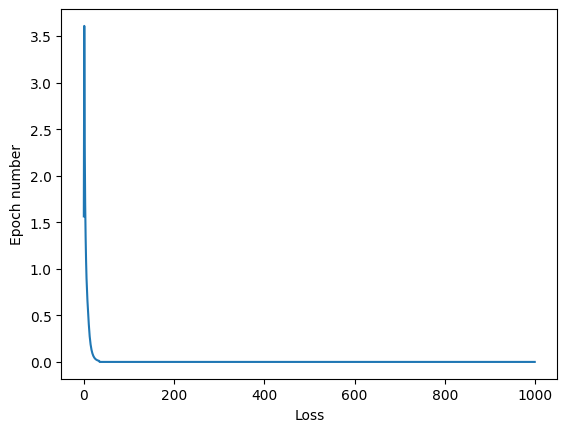

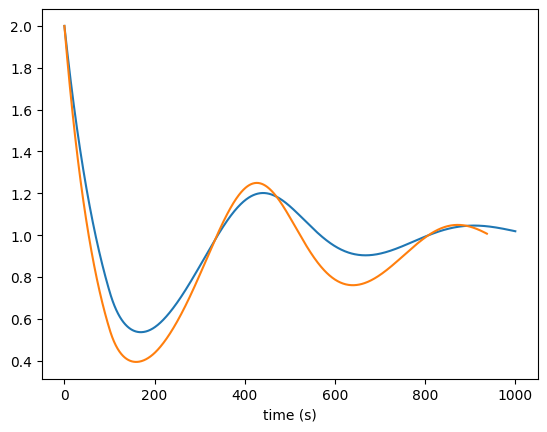

In [11]:
# Loss history
plt.figure(0);
plt.plot(loss_iterations.detach().numpy());
plt.xlabel("Loss");
plt.ylabel("Epoch number");

# Plot 
plt.figure(1);
plt.plot(x_trajectory_True[0].detach().numpy(), label = "true");
plt.plot(Predicted_Trajectory[0].detach().numpy(), label = "discovered");
plt.xlabel("time (s)");

Code to plot the loss function in terms for fixed parameter values as a function of $\tau$

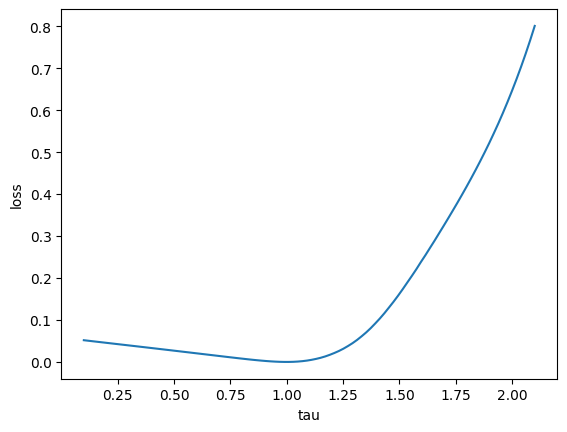

In [12]:
# Build initial model
G : MODEL = MODEL(c_0 = 1.0, c_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 100;
grid_tau = torch.linspace(0.1, 2.1, steps = N_Steps, requires_grad = True);
loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solve(G, x_0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i : int = Predictions_i.shape[1];
    Targets_i = Interpolate_Trajectory(x_trajectory_True, t_trajectory_True, N_i);
    
    # Compute loss
    loss_tau[i] = loss_fn(Predictions_i, Targets_i, grid_tau[i]);

# Plot!
plt.plot(grid_tau.detach().numpy(), loss_tau.detach().numpy());
plt.xlabel("tau");
plt.ylabel("loss");